# Setup

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob
import sklearn
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)


Bad key "text.kerning_factor" on line 4 in
C:\Users\olsso\anaconda3\envs\DT374B\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


# Functions

## File handling

In [2]:
def read_csv(filepath, cols, names):
    df = pd.read_csv(filepath, usecols = cols, names = names, header = None)
    df = df.drop([0], axis = 0) # Remove first row (headers)
    df = df.astype('float64') # Cast data to floats
    
    return df

In [3]:
def get_class(file_path):
    return '_'.join(file_path.split('\\')[-1].split('_')[:-1])

In [4]:
def get_class_df(file_path, df):
    class_name = get_class(file_path)

    return pd.DataFrame({'class': [class_name for _ in range(len(df))]})

In [5]:
def read_acc_mag_csvs():
    X = pd.DataFrame()
    y = pd.DataFrame(columns=['class'])
    
    for file in glob.glob('data/cleaned/acc_mag/*.csv'):

        if 'acc' in file.split('\\')[-1]:
            mag_file = file.replace(file.split('\\')[-1], file.split('\\')[-1].replace('acc', 'mag'))
            
            df_acc = read_csv(file, [1,2,3], ['ax', 'ay', 'az'])
            df_mag = read_csv(mag_file, [1,2,3], ['mx', 'my', 'mz'])
            
            df = pd.concat([df_acc, df_mag], axis=1, join='inner')
            X = X.append(df, ignore_index=True)            

            y = y.append(get_class_df(file, df), ignore_index=True)

    return X, y

In [6]:
def read_acc_mag_gyro_csvs(set, acc = True, mag = True, gyro = True, filter=''):
    X = pd.DataFrame()
    y = pd.DataFrame(columns=['class'])
    
    for file in glob.glob('data/cleaned/acc_mag_gyro/' + set + '/*' + filter + '*.csv'):

        if acc or mag or gyro:
            if 'acc' in file.split('\\')[-1]:
                dfs = []
                
                if acc:
                    df_acc = read_csv(file, [1,2,3], ['ax', 'ay', 'az'])
                    if mag: df_acc = df_acc.groupby(np.arange(len(df_acc))//10).mean()
                    dfs.append(df_acc)
                if mag:
                    mag_file = file.replace(file.split('\\')[-1], file.split('\\')[-1].replace('acc', 'mag'))
                    df_mag = read_csv(mag_file, [1,2,3], ['mx', 'my', 'mz'])
                    dfs.append(df_mag)
                if gyro:
                    gyro_file = file.replace(file.split('\\')[-1], file.split('\\')[-1].replace('acc', 'gyro'))
                    df_gyro = read_csv(gyro_file, [1,2,3], ['gx', 'gy', 'gz'])
                    if mag: df_gyro = df_gyro.groupby(np.arange(len(df_gyro))//10).mean()
                    dfs.append(df_gyro)
                
                df = pd.concat(dfs, axis=1, join='inner')
                X = X.append(df, ignore_index = True)
                
                y = y.append(get_class_df(file, df), ignore_index=True)
        
    return X, y

In [7]:
def get_filepaths_from_folder(path, filter=''):
    files = []
    
    for file in glob.glob(path + '*'):
        if filter in file.split('\\')[-1]:
            files.append(file)
        
    return files

## Classifiers and metrics

In [8]:
from sklearn.metrics import accuracy_score

def get_accuracy(X_test, y_test, classifier):
    return '{:.2%}'.format(accuracy_score(y_test, classifier.predict(X_test)))

In [9]:
from sklearn.metrics import confusion_matrix

def print_conf_matrix(X, y, classifier):
    conf_matrix = confusion_matrix(y, classifier.predict(X))
    print(classifier.classes_)
    print(conf_matrix)

In [10]:
from sklearn.model_selection import cross_val_score

def plot_accuracy_of_k(X, y):
    cv_scores = []
    my_range = range(1, 40)

    for k in my_range:
        knn_cv = KNeighborsClassifier(n_neighbors = k)
        cv_scores.append(cross_val_score(knn_cv, X, y.values.ravel(), cv = 5, scoring='accuracy').mean())

    df_scores = pd.DataFrame(cv_scores, index = my_range)
    df_scores.plot(xlabel = 'k', ylabel = 'Accuracy', legend = False)

## Math

In [11]:
def calc_norms(df):
    l = []
    
    for i in range(len(df)):
        l.append(np.linalg.norm(df.iloc[i]))
        
    return pd.DataFrame({'Norm': l})

In [12]:
def calc_angle(df, axis, i):
    return np.rad2deg(np.arccos(df[axis].iloc[i] / np.linalg.norm(df.iloc[i])))

In [13]:
def calc_angles(df, axis):
    l = []
    
    for i in range(len(df)):
        l.append(calc_angle(df, axis, i))
        
    return pd.DataFrame({'Angle': l})

## Plotting

In [14]:
import itertools

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
# Prepare data for plotting
# Concatenate test data with its predictions and rename classes from categorical to numerical.

def prep_data_for_all_move_plot(df_test, df_pred):
    df = pd.concat([df_test, df_pred], axis=1)
    df.rename(columns={0: 'pred'}, inplace=True)
    df['pred'].replace({'run': 0, 'walk': 1, 'jump': 2, 'pushup': 3}, inplace=True)
    
    return df

In [16]:
def plot_all_move_with_pred(df_test, df_pred, col):
    cmap = matplotlib.cm.get_cmap("brg", 4)

    df = prep_data_for_all_move_plot(df_test, df_pred)

    plot = df[col].plot(
        figsize=(25,5), 
        color='black', 
        title='Combined movements', 
        legend=True, 
        xlim=(0,len(df)), 
        xlabel='Time', 
        xticks=[], 
        ylabel='Data')
    fig = plot.pcolorfast(
        plot.get_xlim(), 
        plot.get_ylim(), 
        df['pred'].values[np.newaxis], 
        cmap=cmap,
        alpha=0.7)
    colorbar = plt.colorbar(fig, ticks=[0.4,1.1,1.85,2.6], label='Prediction')
    colorbar.ax.set_yticklabels(['run', 'walk', 'jump', 'pushup'])

    print('              run                   walk              jump          pushup             run                     walk              jump        pushup')

# Prepare data

### Functions

In [17]:
def print_shapes_train():
    print('Shapes')
    print('X_train_run:\t', X_train_run.shape, '\t\ty_train_run:\t', y_train_run.shape)
    print('X_train_walk:\t', X_train_walk.shape, '\t\ty_train_walk:\t', y_train_walk.shape)
    print('X_train_jump:\t', X_train_jump.shape, '\t\ty_train_jump:\t', y_train_jump.shape)
    print('X_train_pushup:\t', X_train_pushup.shape, '\t\ty_train_pushup:\t', y_train_pushup.shape)

In [18]:
def print_shapes_test():
    print('Shapes')
    print('X_test_run:\t', X_test_run.shape, '\t\ty_test_run:\t', y_test_run.shape)
    print('X_test_walk:\t', X_test_walk.shape, '\t\ty_test_walk:\t', y_test_walk.shape)
    print('X_test_jump:\t', X_test_jump.shape, '\t\ty_test_jump:\t', y_test_jump.shape)
    print('X_test_pushup:\t', X_test_pushup.shape, '\t\ty_test_pushup:\t', y_test_pushup.shape)

### Read and append

#### Training set

In [19]:
# Raw csv's read into dataframes divided by class

X_train_run, y_train_run = read_acc_mag_gyro_csvs('train', acc=True, mag=False, gyro=True, filter='run')
X_train_walk, y_train_walk = read_acc_mag_gyro_csvs('train', acc=True, mag=False, gyro=True, filter='walk')
X_train_jump, y_train_jump = read_acc_mag_gyro_csvs('train', acc=True, mag=False, gyro=True, filter='jump')
X_train_pushup, y_train_pushup = read_acc_mag_gyro_csvs('train', acc=True, mag=False, gyro=True, filter='pushup')

print_shapes_train()

Shapes
X_train_run:	 (12500, 6) 		y_train_run:	 (12500, 1)
X_train_walk:	 (7500, 6) 		y_train_walk:	 (7500, 1)
X_train_jump:	 (9000, 6) 		y_train_jump:	 (9000, 1)
X_train_pushup:	 (7800, 6) 		y_train_pushup:	 (7800, 1)


In [20]:
# Maximum number of rows

n_rows_train = 7168
n_rows_train/256     # Test that n_rows is evenly divisible by a number which is a factor of 2

28.0

In [21]:
# Drop rows > n_rows

X_train_run, y_train_run = X_train_run[:n_rows_train], y_train_run[:n_rows_train]
X_train_walk, y_train_walk = X_train_walk[:n_rows_train], y_train_walk[:n_rows_train]
X_train_jump, y_train_jump = X_train_jump[:n_rows_train], y_train_jump[:n_rows_train]
X_train_pushup, y_train_pushup = X_train_pushup[:n_rows_train], y_train_pushup[:n_rows_train]

print_shapes_train()

Shapes
X_train_run:	 (7168, 6) 		y_train_run:	 (7168, 1)
X_train_walk:	 (7168, 6) 		y_train_walk:	 (7168, 1)
X_train_jump:	 (7168, 6) 		y_train_jump:	 (7168, 1)
X_train_pushup:	 (7168, 6) 		y_train_pushup:	 (7168, 1)


In [22]:
# Append all classes in one dataframe

X_train_df = X_train_run.append(X_train_walk.append(X_train_jump.append(X_train_pushup, ignore_index=True), ignore_index=True), ignore_index=True)
y_train_df = y_train_run.append(y_train_walk.append(y_train_jump.append(y_train_pushup, ignore_index=True), ignore_index=True), ignore_index=True)

X_train_df.shape, y_train_df.shape

((28672, 6), (28672, 1))

#### Test set

In [23]:
# Raw csv's read into dataframes divided by class

X_test_run, y_test_run = read_acc_mag_gyro_csvs('test', acc=True, mag=False, gyro=True, filter='run')
X_test_walk, y_test_walk = read_acc_mag_gyro_csvs('test', acc=True, mag=False, gyro=True, filter='walk')
X_test_jump, y_test_jump = read_acc_mag_gyro_csvs('test', acc=True, mag=False, gyro=True, filter='jump')
X_test_pushup, y_test_pushup = read_acc_mag_gyro_csvs('test', acc=True, mag=False, gyro=True, filter='pushup')

print_shapes_test()

Shapes
X_test_run:	 (3500, 6) 		y_test_run:	 (3500, 1)
X_test_walk:	 (1500, 6) 		y_test_walk:	 (1500, 1)
X_test_jump:	 (1800, 6) 		y_test_jump:	 (1800, 1)
X_test_pushup:	 (2000, 6) 		y_test_pushup:	 (2000, 1)


In [24]:
# Maximum number of rows

n_rows_test = 1280
n_rows_test/256     # Test that n_rows is evenly divisible by a number which is a factor of 2

5.0

In [25]:
# Drop rows > n_rows

X_test_run, y_test_run = X_test_run[:n_rows_test], y_test_run[:n_rows_test]
X_test_walk, y_test_walk = X_test_walk[:n_rows_test], y_test_walk[:n_rows_test]
X_test_jump, y_test_jump = X_test_jump[:n_rows_test], y_test_jump[:n_rows_test]
X_test_pushup, y_test_pushup = X_test_pushup[:n_rows_test], y_test_pushup[:n_rows_test]

print_shapes_test()

Shapes
X_test_run:	 (1280, 6) 		y_test_run:	 (1280, 1)
X_test_walk:	 (1280, 6) 		y_test_walk:	 (1280, 1)
X_test_jump:	 (1280, 6) 		y_test_jump:	 (1280, 1)
X_test_pushup:	 (1280, 6) 		y_test_pushup:	 (1280, 1)


In [26]:
# Append all classes in one dataframe

X_test_df = X_test_run.append(X_test_walk.append(X_test_jump.append(X_test_pushup, ignore_index=True), ignore_index=True), ignore_index=True)
y_test_df = y_test_run.append(y_test_walk.append(y_test_jump.append(y_test_pushup, ignore_index=True), ignore_index=True), ignore_index=True)

X_test_df.shape, y_test_df.shape

((5120, 6), (5120, 1))

## Standard deviation

### Get dataframe with stddev

In [27]:
from statistics import stdev

def calc_stdev(data, n):
    l = []
    count = 0

    while count <= len(data):
        count += 1

        if count % n == 0:
            l.append(stdev(data[count-n:count]))

    return pd.DataFrame({'stdev': l})

In [28]:
def get_stdev_dfs(df_x, df_y, n):
    df = pd.concat([df_x, df_y], axis=1)
    classes = df['class'].unique()
    X = pd.DataFrame(columns=['stdev'])
    y = pd.DataFrame(columns=['class'])

    for i in range(0, len(classes)):
        df_temp = calc_stdev(df[df['class'] == classes[i]]['ay'], n)
        X = X.append(df_temp, ignore_index=True)
        y = y.append([pd.DataFrame({'class': [classes[i] for _ in range(len(df_temp))]})], ignore_index=True)

    return X, y

# RNN Classification

In [29]:
n_timesteps = 64

In [30]:
# Reshape df's, convert to numpy arrays and encode y

from sklearn.preprocessing import LabelEncoder

# Reshape and convert X
X_train = np.reshape(X_train_df.to_numpy(), (X_train_df.shape[0] // n_timesteps, n_timesteps, X_train_df.shape[1]))
X_test = np.reshape(X_test_df.to_numpy(), (X_test_df.shape[0] // n_timesteps, n_timesteps, X_test_df.shape[1]))

# One-hot encode y
enc = LabelEncoder()

y_train_np = y_train_df['class'][::n_timesteps].to_numpy()
y_train_np_reshaped_labelenc = enc.fit_transform(y_train_np)
y_train = keras.utils.to_categorical(y_train_np_reshaped_labelenc)

y_test_np = y_test_df['class'][::n_timesteps].to_numpy()
y_test_np_reshaped_labelenc = enc.fit_transform(y_test_np)
y_test = keras.utils.to_categorical(y_test_np_reshaped_labelenc)

print(f'\tX.shape\t\ty.shape')
print(f'Train:\t{X_train.shape}\t{y_train.shape}')
print(f'Test:\t{X_test.shape}\t{y_test.shape}')

	X.shape		y.shape
Train:	(448, 64, 6)	(448, 4)
Test:	(80, 64, 6)	(80, 4)


In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU

model = Sequential()

# Layer 1
model.add(LSTM(units=n_timesteps, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Layer 2
model.add(Dense(units=4, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Using TensorFlow backend.


In [32]:
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2)

Train on 358 samples, validate on 90 samples
Epoch 1/20
358/358 [==============================] - 1s 2ms/step - loss: 1.4195 - accuracy: 0.3128 - val_loss: 1.2381 - val_accuracy: 0.3333
Epoch 2/20
358/358 [==============================] - 0s 1ms/step - loss: 0.9900 - accuracy: 0.6620 - val_loss: 0.9436 - val_accuracy: 0.9444
Epoch 3/20
358/358 [==============================] - 0s 966us/step - loss: 0.7151 - accuracy: 0.7765 - val_loss: 0.8138 - val_accuracy: 0.9111
Epoch 4/20
358/358 [==============================] - 0s 865us/step - loss: 0.5239 - accuracy: 0.8715 - val_loss: 0.7004 - val_accuracy: 0.9111
Epoch 5/20
358/358 [==============================] - 0s 890us/step - loss: 0.3582 - accuracy: 0.9358 - val_loss: 0.6109 - val_accuracy: 0.9222
Epoch 6/20
358/358 [==============================] - 0s 870us/step - loss: 0.2462 - accuracy: 0.9609 - val_loss: 0.5721 - val_accuracy: 0.9222
Epoch 7/20
358/358 [==============================] - 0s 862us/step - loss: 0.1493 - accuracy: 

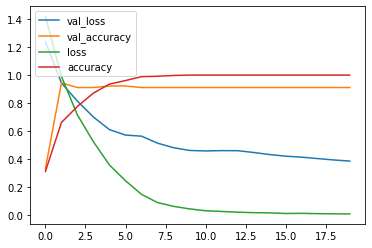

In [33]:
pd.DataFrame(history.history).plot()

In [34]:
tf.math.confusion_matrix(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1))

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[20,  0,  0,  0],
       [ 1, 18,  0,  1],
       [ 0,  0, 20,  0],
       [ 0,  0,  0, 20]])>

In [35]:
# Evaluate the model

ev = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss = {ev[0]:.2f}\tAccuracy = {ev[1]:.2%}')

Loss = 0.14	Accuracy = 97.50%


In [36]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test_np, y_pred=enc.inverse_transform(model.predict(X_test).argmax(axis=1)))

Confusion matrix, without normalization
[[20  0  0  0]
 [ 1 18  0  1]
 [ 0  0 20  0]
 [ 0  0  0 20]]


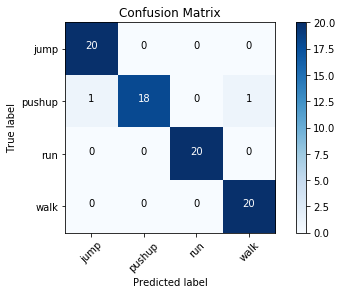

In [40]:
plot_confusion_matrix(cm=cm, classes=np.unique(y_test_np), title='Confusion Matrix')